In [2]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from stable_baselines3 import PPO
import time
import gymnasium as gym


plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 32  # Nothing special with 16, feel free to change
        hidden_space2 = 64  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [3]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [3]:
# Create and wrap the environment
env = gym.make("Humanoid-v4", render_mode = "human", forward_reward_weight = 5, healthy_reward = 20)
#env = gym.make("Humanoid-v4", forward_reward_weight = 5, healthy_reward = 20)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env)  # Records episode-reward
#wrapped_env.render_mode("human")

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []
total_steps = 0


#for seed in [1, 2, 3, 5, 8, 13, 21]:  # Fibonacci seeds
for seed in [1]:
    steps_in_seed = 0

    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    #agent = REINFORCE(obs_space_dims, action_space_dims)
    agent = PPO('MlpPolicy', wrapped_env, verbose=0)
    agent.learn(total_timesteps=100000,progress_bar=True)
    reward_over_episodes = []

    for episode in range(10):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False

        steps = 0

        while not done:
            steps+=1
            #action = agent.sample_action(obs)
            action, _states = agent.predict(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            #agent.rewards.append(reward)
            

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of times
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated
            wrapped_env.render()
        
        steps_in_seed+=steps
        reward_over_episodes.append(wrapped_env.return_queue[-1])
        #agent.update()
        if (episode+1) % 10 == 0:
            avg_reward = int(np.mean(reward_over_episodes[-10:]))
            print("Episode:", episode+1, "Average Reward:", avg_reward)
            print("Current total no. steps: ", steps_in_seed)
    
    total_steps+=steps_in_seed
    rewards_over_seeds.append(reward_over_episodes)

    print("total no. steps: ", total_steps)

Output()

c:\Users\anfis\anaconda3\envs\ML2\lib\site-packages\glfw\__init__.py:916: GLFWError: (65537) b'The GLFW library is 
not initialized'
  warnings.warn(message, GLFWError)

Episode: 10 Average Reward: 1322
Current total no. steps:  624
total no. steps:  624


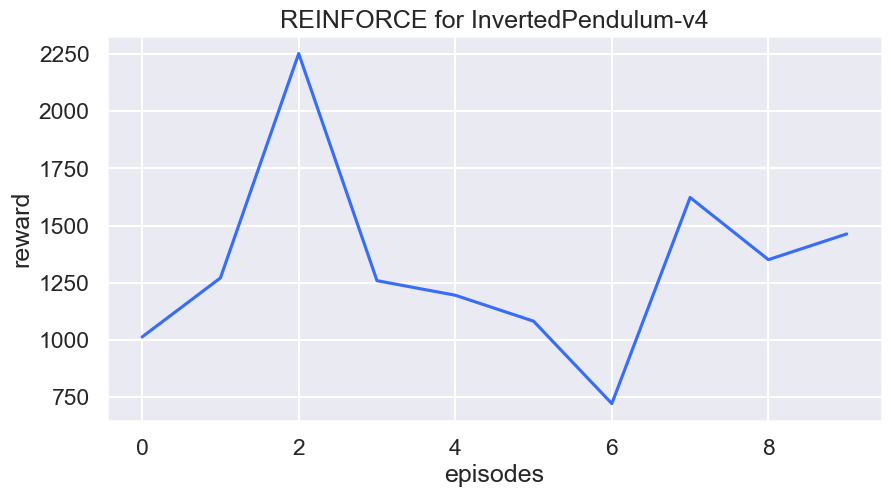

In [4]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

In [2]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('rewards_plot', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(rewards_to_plot, f)

with open('rewards_over_seeds', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(rewards_over_seeds, f)

torch.save(agent, 'agent')

NameError: name 'rewards_to_plot' is not defined

In [1]:
# Create and wrap the environment
env = gym.make("Humanoid-v4", render_mode = "human")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []
total_steps = 0

for seed in [1]:  # Fibonacci seeds

    steps_in_seed = 0

    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    #agent = torch.load('agent2')
    reward_over_episodes = []

    for episode in range(10):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False

        steps = 0

        while not done:
            steps+=1
            action, _states = agent.predict(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            #agent.rewards.append(reward)
            

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of times
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated
        
        steps_in_seed+=steps
        reward_over_episodes.append(wrapped_env.return_queue[-1])
        #agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)
            print("Current total no. steps: ", steps_in_seed)
    
    total_steps+=steps_in_seed
    rewards_over_seeds.append(reward_over_episodes)

    print("total no. steps: ", total_steps)


NameError: name 'gym' is not defined